In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np


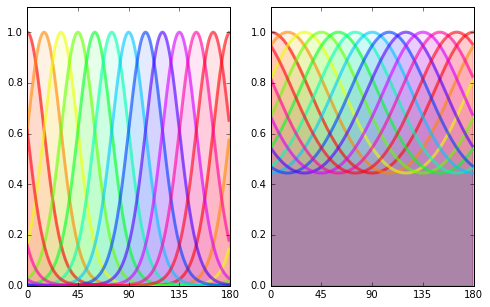

In [2]:
import matplotlib.pyplot as plt

def envelope(th, theta, B_theta):
    if B_theta==np.inf:
        env = np.ones_like(th) 
    elif B_theta==0:
        env = np.zeros_like(th)
        env[np.argmin(th < theta)] = 1.
    else:
        env = np.exp((np.cos(2*(th-theta))-1)/4/B_theta**2)
    return env/env.max()        

N_theta = 12
bins = 180
th = np.linspace(0, np.pi, bins, endpoint=False)
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
for i, B_theta_ in enumerate([np.pi/12, np.pi/4]):#[0, np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4, np.pi/2, np.inf]:
    for theta, color in zip(np.linspace(0, np.pi, N_theta, endpoint=False), 
                            [plt.cm.hsv(h) for h in np.linspace(0, 1, N_theta)]):
        axs[i].plot(th*180/np.pi, envelope(th, theta, B_theta_), alpha=.6, color=color, lw=3)
        axs[i].fill_between(th*180/np.pi, 0, envelope(th, theta, B_theta_), alpha=.1, color=color)
    axs[i].set_xlim([0, 180])
    axs[i].set_ylim([0, 1.1])
    axs[i].set_xticks(np.linspace(0, 180, 5, endpoint=True) )#to specify number of tick…
fig.savefig('../figs/tuning_functions.png', dpi = 600)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow
from matplotlib.colors import hsv_to_rgb

def model(future=False):
    fig = plt.figure(figsize=(8, 8))

    ax2 = fig.add_subplot(111, alpha=0., axis_bgcolor=(1,1,1,0))
    ax = fig.add_subplot(111, projection='polar', alpha=0., axis_bgcolor=(1,1,1,0))

    opts= dict(ha='center', fontsize=14)
    N = 24
    s = 42
    theta = np.linspace(0, 2*np.pi, N+1, endpoint=True)

    ## connexions
    N_arrow = 3
    dthetas = alphas = np.linspace(-N_arrow, N_arrow, 2*N_arrow+1, endpoint=True)
    dthetas *= 1.75*np.pi/N
    alphas = np.exp( - alphas**2/ .4**2 / 2)
    #print(alphas)
    for dtheta, alpha in zip(dthetas, alphas):
        plt.arrow(np.pi/2, 1.4, dtheta, -.2, color='k', alpha=alpha)

        plt.arrow(0, 1.1, dtheta, -.1, color='r', alpha=alpha)
        plt.arrow(0, 1.1, dtheta, 0., color='r', alpha=alpha)

        plt.arrow(np.pi, .9, dtheta, .1, color='b', alpha=alpha)
        plt.arrow(np.pi, .9, dtheta, 0., color='b', alpha=alpha)
        #set_connectionstyle("arc,angleA=0,armA=30,rad=10")
        #set_arrowstyle("Fancy,head_length=0.2")

    ## neurones
    colors = theta
    for r, c in zip([.9, 1.1, 1.4], ['b', 'r', 'k']):
        ax.plot(theta, r*np.ones_like(theta), c=c, alpha=.4)
        c = ax.scatter(theta[:-1], r*np.ones_like(theta[:-1]), c=c, s=s)
        #c.set_alpha(0.15)

    ## entrée
    N = 1080
    theta = np.linspace(0, 2*np.pi, N)
    ax.fill_between(theta, 1.45, 1.45 + envelope(theta/2, np.pi/4, np.pi/24)/2.5, lw=0, color='g', alpha=.3)

    ax.set_ylim((0, 1.85))

    ax.text(-np.pi/2, 1.25, 'Excitateurs', **opts)
    ax.text(-np.pi/2, .8, 'Inhibiteurs', **opts)
    if future:

        ax.text(np.pi/2, 1.6, 'Entrée\ndirectionnelle', **opts)
        ax.text(-np.pi/2, 1.55, 'convergence corticale', **opts)
    else:
        
        ax.text(np.pi/2, 1.6, 'Entrée\norientationnelle', **opts)
        ax.text(-np.pi/2, 1.55, 'convergence thalamo-corticale', **opts)

    N = 12
    for theta in np.linspace(0, 2*np.pi, N, endpoint=False):
        r, angle, l = .15, theta, .1
        if future:
            ax2.add_patch(Arrow((r-l/2)*np.sin(angle)+.5, (r-l/2)*np.cos(angle)+.5, l*np.sin(angle), l*np.cos(angle), width=.06, color='k'))
        else:
            ax2.add_patch(Rectangle([r*np.sin(angle)+.5, r*np.cos(angle)+.5], .01, .04, angle=theta/2*180/np.pi, color=hsv_to_rgb([theta/2/np.pi, 1, 1])))            

    for ax_ in [ax, ax2]:
        ax_.grid(False, axis='both')

        ax_.set_xticks([])
        ax_.set_yticks([])
        ax_.set_axis_off()
    
    fig.subplots_adjust(hspace = .0, wspace = .0, left=0.01, bottom=0.01, right=.99, top=.99)
    return fig, ax

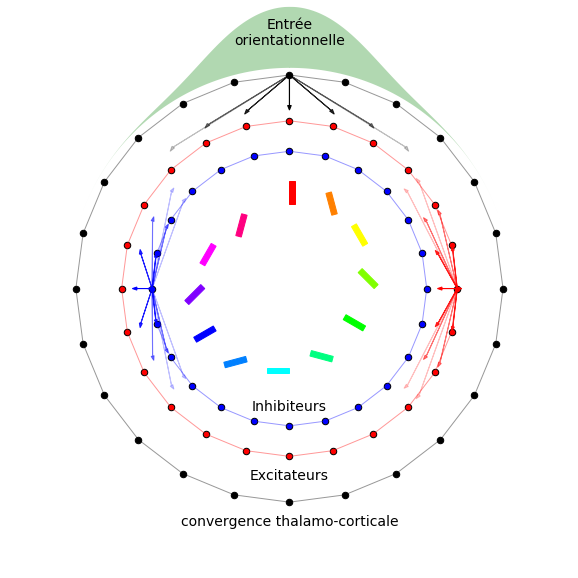

In [4]:
fig, ax = model()
fig.savefig('../figs/ring_model.png', dpi=600)

# Le Ring

Une fois le RRNN créé, paramétré et optimisé, nous lui ajoutons certaines propriétés dans le but de le transformer en "ring". Ce dernier va nous permettre d'implémenter le modèle de la sélectivité à l'orientation reproduisant ce qui peut être observé au sein des colonnes corticales du cortex visuel primaire.

Le ring est un réseau récurrent disposant d'une certaine topologie. En effet, selon sa position dans le réseau, un neurone possède une certaine sélectivité à l'orientation et les connexions sont locales dans l'espace des orientations. 
Quelques propriétés de la réponse à l'orientation vont conditionner cette sélectivité et induire un certain comportement du réseau, en réponse à une orientation présentée sur son entrée :

-  $m$ est l'angle d'orientation préferée d'un neurone. Cela signifie que ce dernier aura une réponse maximale si une orientation d'un angle $\theta$, tel que $\theta = m$, est présentée. Notons que le ring est construit de telle sorte que toutes les orientations sont codées avec une précision de vingt minutes d'arc et qu'il est non orienté, ainsi $0\leq m \leq \pi$.
- la bandwidth $\sigma$ est la largeur à mi-hauteur de la courbe d'accord d'un neurone. Elle sert à représenter la sélectivité de la réponse neuronale à d'autres orientations que celle préferée. Dans ce modèle, les bandwidth ne sont pas paramétrés par neurone mais plutôt par type de connexion entre les populations E et I. Nous implémentons également une bandwidth dans les connexions entre la source et la population E. Ainsi, nous cherchons à ce que les neurones d'une colonne corticale aient une certaine bandwith de sélectivité à l'orientation du fait de leurs connexions avec d'autres colonnes.

Une fonction d'accord est aussi implémentée. Cette fonction permet de calculer le poids synaptique de chacune des connexions d'une projection à partir des propriétés décrites plus haut. De part sa généralité, nous utiliserons une loi de Von Mises (loi normale circulaire) définie par :

$$
f(\theta) = \frac{1}{Z(\kappa)} \cdot e^{\kappa{cos(2(\theta - m))}}
$$
où $Z$ est la fonction de normalisation. Par analogie avec la déviation standard d'une loi Gaussienne, on définit $\kappa = \frac {1}{\sigma^{2}}$. Notons que $f(\theta+\pi) = f(\theta)$.



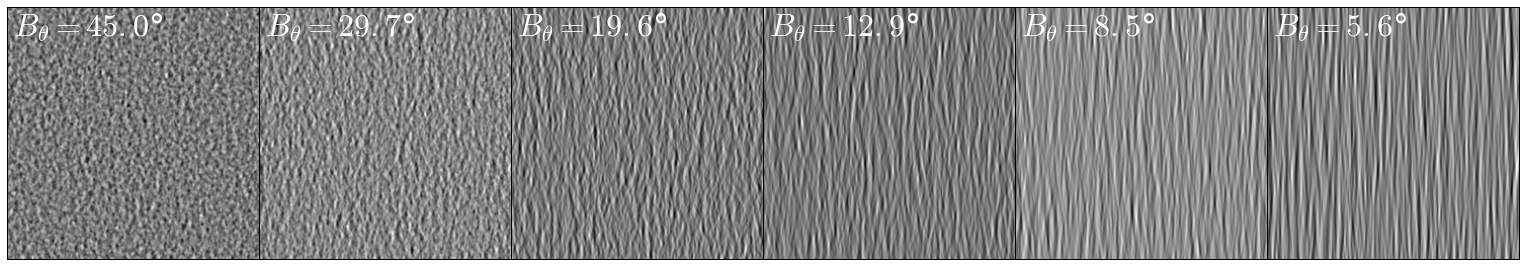

In [5]:
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 16)


N_theta = 6
bw_values = np.pi*np.logspace(-2, -5, N_theta, base=2)
fig_width = 21


fig, axs = plt.subplots(1, N_theta, figsize=(fig_width, fig_width/N_theta))
for i_ax, B_theta in enumerate(bw_values):
    mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0.,  
                                         theta=np.pi/2, B_theta=B_theta)
    im = mc.random_cloud(mc_i)
                
    axs[i_ax].imshow(im[:, :, 0], cmap=plt.gray())
    axs[i_ax].text(5, 29, r'$B_\theta=%.1f$°' % (B_theta*180/np.pi), color='white', fontsize=32)
    axs[i_ax].set_xticks([])
    axs[i_ax].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(hspace = .0, wspace = .0, left=0.0, bottom=0., right=1., top=1.)

import os
fig.savefig(os.path.join('../figs', 'orientation_tuning.png'))

## Le ring feed-forward face au ring récurrent

### Différences dans les motifs d'activité

Ici, nous montrons les différences d'activité entre un ring avec une connectivité feed- forward et un ring possédant une connectivité récurrente. La population excitatrice d'un ring récurrent bien accordé doit représenter de façon précise l'orientation soumise en entrée même si la distibution d'orientation à une grande largeur de bande. 

Pour vérifier cela, nous paramétrons l'activité des neurones de la population source de telle sorte que celle-ci représente une orientation de contraste de 90° et que la largeur de bande de la distribution soumise soit de 40°. Nous générons alors les rasterplots des trois populations du ring feed-forward ainsi que du ring récurrent.

Si l'on s'intéresse à l'activité de la population excitatrice pour chacun des deux types de ring, nous observons bien que le ring feed-forward reproduit l'activité de la population d'entrée alors que le ring récurrent présente une activité plus locale. Et, puisque les neurones du ring sont organisés selon leur préference à l'orientation, cela signifie que la connectivité récurrente entraine une représentation de l'orientation plus précise. Ainsi la réponse du ring recurrent est plus robuste à l'imprecision de l'orientation présentée.

### Différences dans les courbes d'accord

Par un ajustement de la distribution de Von Mises aux taux de décharge de la population excitatrice, nous tentons maintenant de montrer, de façon plus quantitative, l'effet de chacun des deux types de connectivité.

Nous simulons donc le ring feed-forward et le ring récurrent avec différentes entrées, des distributions d'orientation ayant différentes largeurs de bande. Pour chacun des deux types de ring, nous mesurons le taux de décharge moyen de la population excitatrice et nous ajustons ensuite ces taux de décharge par des distributions de Von Mises.

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH
/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.



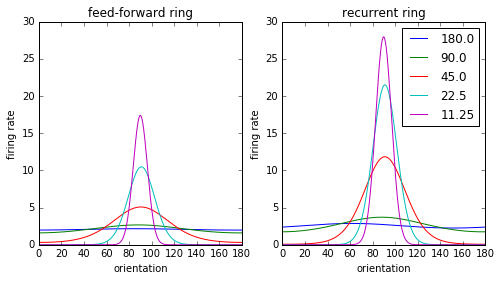

In [7]:
from RRNN import RRNN
bw_values = 180*np.logspace(0, -4, 5, base=2)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for i in range(2):
    for bw_value in bw_values:
        if i==1:
            net = RRNN(c=1, b_input=bw_value)
        else:
            net = RRNN(ff_ring=True, b_input=bw_value)
        df, spikesE, spikesI = net.model()
        theta, fr, result = net.fit_vonMises(spikesE)
        #print(result.best_fit.mean())
        axs[i].plot(theta*180/np.pi, result.best_fit, label=str(bw_value))

    axs[i].set_xlabel('orientation')
    axs[i].set_ylabel('firing rate')
    axs[i].axis('tight')
    axs[i].set_ylim([0, 30])
axs[0].set_title('feed-forward ring')
axs[1].set_title('recurrent ring')

plt.legend(loc='best')
plt.show()

fig.savefig('../figs/ring_feed-forward_vs_recurrent.png', dpi = 600)

In [ ]:
bw_values = 180*np.logspace(0, -4, 5, base=2)
BW = np.zeros((2, len(bw_values)))
for i in range(2):
    for i_bw, bw_value in enumerate(bw_values):
        if i==1:
            net = RRNN(time=time, c=1, b_input=bw_value)
        else:
            net = RRNN(time=time, ff_ring=True, b_input=bw_value)
        df, spikesE, spikesI = net.model()
        theta, fr, result = net.fit_vonMises(spikesE)
        BW[i, i_bw] = result.params['sigma'].value
    

In [ ]:
  
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(BW[0, i_bw], 'k.', label='feed-forward ring')
ax.plot(BW[1, i_bw], 'r.', label='recurrent ring')
        
ax.set_xlabel('orientation')
ax.set_ylabel('firing rate')
ax.axis('tight')
#ax.set_ylim([0, 30])

plt.legend(loc='best')
plt.show()

fig.savefig('../figs/ring_feed-forward_vs_recurrent_BW.png', dpi = 600)